# Animate modeling of fluid channel

This notebook is designed for animating the
modeling of void fraction in a microfluidic channel.

Created on Mon Apr 21 9:35:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [6]:
import os
import cv2
import numpy as np
from glob import glob
from time import time
import matplotlib.pyplot as plt

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

def get_channel(channel_shape):
    """Return list of all index coordinates of the empty channel."""
    # get list of ordered pairs of channel index coordinates
    yy_channel, xx_channel = np.indices(channel_shape)
    channel_coords = np.column_stack(
        (np.ravel(xx_channel), np.ravel(yy_channel)))
    return channel_coords

def get_bubbles(model_info, channel):
    """Get random bubble radii and center coordinates."""
    # get number of bubbles and radii limits
    num = model_info['num_of_bubbles_to_try']
    min_rad = model_info['min_rad_um']/model_info['um_per_pixel'],
    max_rad = model_info['max_rad_um']/model_info['um_per_pixel']
    # get random radii and sort from large to small
    rad_list = np.random.uniform(min_rad, max_rad, num)
    rad_list = np.clip(rad_list, min_rad, max_rad)
    rad_list = np.sort(rad_list)[::-1]
    # get random x- and y-positions within the channel
    x_list = np.random.uniform(0, len(channel[0]), num)
    y_list = np.random.uniform(0, len(channel), num)
    return {
        'rad': rad_list,
        'rad_squared': np.square(rad_list),
        'x': x_list,
        'y': y_list}

## Read image data from file

In [7]:
# load model parameters from file
model_info_path = os.path.join(os.getcwd(), 'model_info.npy')
model_info = np.load(model_info_path, allow_pickle=True)[()]

## Create a model and export images

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


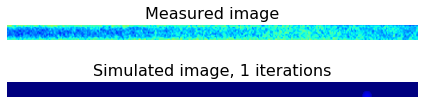

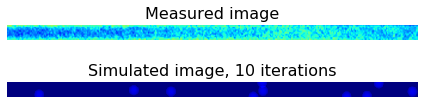

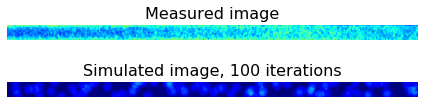

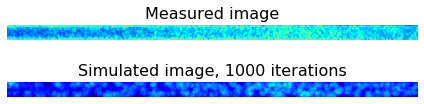

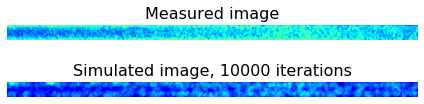

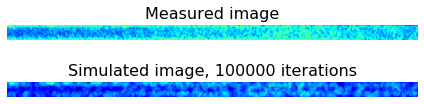

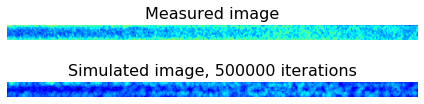

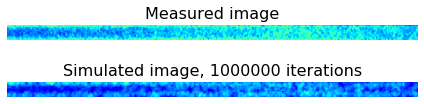

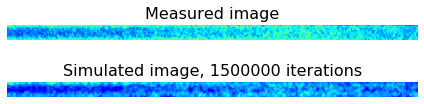

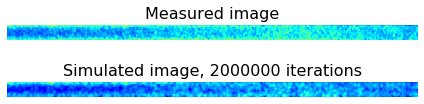

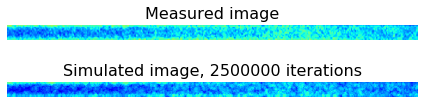

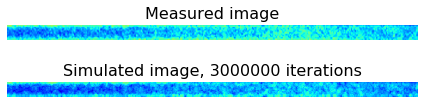

In [8]:
# get target image to model
measured_image = model_info['channels']['75lbh000010']['img_voidfrac']

# get list of channel index coordinates and potential bubbles
model_info['num_of_bubbles_to_try'] = 5000000
channel_coords = get_channel(measured_image.shape)
bub_dict = get_bubbles(model_info, measured_image)

# simulate empty channel to populate with simulated bubbles
img_model= np.zeros_like(measured_image)

# pixels to add to each bubble as a fluid buffer
buffer_pixels = model_info['buffer_um']/model_info['um_per_pixel']

# loop over each bubble to try and fit into the channel
for i in range(4000100):

    img_export_path = os.path.join(os.getcwd(),
                                   'model_images',
                                   'channel_img_'+str(i).zfill(8)+'.jpg')
    
    # get z-profile of new bubble
    bub_profile = 2*np.sqrt(bub_dict['rad_squared'][i]
                            - np.square(channel_coords[:, 0]-bub_dict['x'][i])
                            - np.square(channel_coords[:, 1]-bub_dict['y'][i])) + buffer_pixels

    # convert nan to 0 and reshape to channel size
    bub_profile = np.where(np.isnan(bub_profile),
                           0, bub_profile).reshape(img_model.shape)

    # add new bubble to channel if it will fit
    if np.all(img_model + bub_profile <= 1.02*measured_image):
        img_model += bub_profile

    if (i+1) in [1, 10, 100, 1000, 10000, 100000, 500000, 1000000,
                 1500000, 2000000, 2500000, 3000000]:
        fig = plt.figure()
        fig.set_size_inches(6, 2)
        
        # show original channel image
        plt.subplot(2, 1, 1)
        plt.imshow(measured_image, origin='lower', cmap='jet', vmin=0, vmax=250)
        plt.title('Measured image', fontsize=16)
        plt.axis('off')
        
        # show simulated channel image
        plt.subplot(2, 1, 2)
        plt.imshow(img_model, origin='lower', cmap='jet', vmin=0, vmax=250)
        plt.title('Simulated image, {} iterations'.format(i+1), fontsize=16)
        plt.axis('off')

        # save figure
        plt.tight_layout()
        plt.savefig(img_export_path, format='jpg', dpi=250)
        plt.show()


## Create video using exported images

In [9]:
def create_video(image_folder, video_name, fps=2, reverse=False):
    """ Create video out of images saved in a folder"""
    images = [img for img in os.listdir(image_folder) if img.endswith('.jpg')]
    if reverse: images = images[::-1]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, -1, fps, (width,height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()

video_name = os.path.join(os.getcwd(), 'model_building_animation.avi')

create_video(os.path.join(os.getcwd(),'model_images'), video_name)